# Anomaly Detection Evaluation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import evaluation
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

In [2]:
filename = "all_features_(B1)_2017-04-09" #30min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_30 = pd.read_csv(filename, index_col=0)
B1_30.index = pd.to_datetime(B1_30.index)
B1_30_s = ad_pp.scale_robust(B1_30)

filename = "all_features_(B2)_2017-04-09" #30min, B2
filename = os.path.join('..', 'CSV', filename + ".csv")
B2_30 = pd.read_csv(filename, index_col=0)
B2_30.index = pd.to_datetime(B2_30.index)
B2_30_s = ad_pp.scale_robust(B2_30)

In [3]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-09-14 00:00:00.000000'
labeled = client.query_tagged_anomalies(start_date, end_date)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Evaluation

In [4]:
clf_B1 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B1.fit(B1_30_s)
clf_B2 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B2.fit(B2_30_s)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [5]:
B1_w_probs = GMM.add_sorted_anomaly_probs(clf_B1, B1_30_s)
B2_w_probs = GMM.add_sorted_anomaly_probs(clf_B2, B2_30_s)

### Segmentation

In [6]:
anomaly_sizes = [200, 250, 500, 750, 1000]
segmenter = evaluation.AnomalySegmenter()
evolution_segments_B1 = list(segmenter.segments_generator(B1_w_probs, anomaly_sizes))
evolution_segments_B2 = list(segmenter.segments_generator(B2_w_probs, anomaly_sizes))

In [7]:
tables = [evaluation.compare_segmented_with_labeled(segments_B1, segments_B2, labeled)
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

# total_segmented_Bx computes the total number of anomalies in all segments for every step in the evolution
total_segmented_B1 = [sum([s.get_nb_anomalies() for s in segments_B1]) for segments_B1 in evolution_segments_B1]
total_segmented_B2 = [sum([s.get_nb_anomalies() for s in segments_B2]) for segments_B2 in evolution_segments_B2]

nb_segments_B1 = [len(segments_B1) for segments_B1 in evolution_segments_B1]
nb_segments_B2 = [len(segments_B2) for segments_B2 in evolution_segments_B2]

for i in range(len(anomaly_sizes)):
    display(tables[i])
    display("Number of anomalies used: {}".format(anomaly_sizes[i]))
    display("Number of anomalies in segments B1: {}".format(total_segmented_B1[i]))
    display("Number of anomalies in segments B1: {}".format(total_segmented_B2[i]))
    display("Total number of segments B1: {}".format(nb_segments_B1[i]))
    display("Total number of segments B2: {}".format(nb_segments_B2[i]))
    

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               2               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               2               1               1   
2016-06-30 21:23:00               9               1               5   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               0   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              49               1               0   
2016-08-02 17:50:00              49               1               0   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              18   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2    mean_score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -3578.996095         MKI8  
2016-06-05 17:18:00               1 -22723.540169         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1   -875.841555         MKI2  
2016-06-30 21:23:00               1  -1320.045504         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               0      0.000000         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               0   -275.724852         MKI2  
2016-08-02 17:50:00               0   -275.724852         MKI2  
2016-08-03 08:05:00               1   -236.606298         MKI2  
2016-08-04 14:03:41               0      0.000000         MKI2  
2016-08-21 20:00:00               1   -723.578194         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

'Number of anomalies used: 200'

'Number of anomalies in segments B1: 200'

'Number of anomalies in segments B1: 200'

'Total number of segments B1: 44'

'Total number of segments B2: 64'

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               2               1               1   
2016-06-30 21:23:00              15               1              13   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               2   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              57               1               0   
2016-08-02 17:50:00              57               1               0   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              32   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2    mean_score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -2454.015594         MKI8  
2016-06-05 17:18:00               1 -22723.540169         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1   -875.841555         MKI2  
2016-06-30 21:23:00               1   -797.821899         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               1   -119.389962         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               0   -248.524300         MKI2  
2016-08-02 17:50:00               0   -248.524300         MKI2  
2016-08-03 08:05:00               0      0.000000         MKI2  
2016-08-04 14:03:41               0      0.000000         MKI2  
2016-08-21 20:00:00               1   -421.904904         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

'Number of anomalies used: 250'

'Number of anomalies in segments B1: 249'

'Number of anomalies in segments B1: 240'

'Total number of segments B1: 45'

'Total number of segments B2: 66'

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               2   
2016-06-05 17:18:00               0               0               2   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00              14               1               1   
2016-06-30 21:23:00              42               1              77   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               3   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              98               1               1   
2016-08-02 17:50:00              98               1               1   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               1               1               2   
2016-08-21 20:00:00               0               0              62   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2    mean_score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -2371.047150         MKI8  
2016-06-05 17:18:00               1 -11356.733255         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1   -755.316809         MKI2  
2016-06-30 21:23:00               1   -299.521220         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               1    -85.199923         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               1    -86.961679         MKI2  
2016-08-02 17:50:00               1    -86.961679         MKI2  
2016-08-03 08:05:00               0      0.000000         MKI2  
2016-08-04 14:03:41               1    -14.843761         MKI2  
2016-08-21 20:00:00               1   -219.415951         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

'Number of anomalies used: 500'

'Number of anomalies in segments B1: 498'

'Number of anomalies in segments B1: 459'

'Total number of segments B1: 55'

'Total number of segments B2: 92'

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               4               1               2   
2016-06-05 17:18:00               1               1               3   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00              37               1               8   
2016-06-30 21:23:00              84               1             100   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0              11   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             143               1               1   
2016-08-02 17:50:00             143               1               1   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               1               1               2   
2016-08-21 20:00:00               2               1              70   
2016-08-22 21:30:30               0               0               2   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2   mean_score installation  
timestamps                                                     
2016-05-30 14:00:00               1 -1800.377561         MKI8  
2016-06-05 17:18:00               1 -3796.537457         MKI8  
2016-06-18 19:59:00               0     0.000000         MKI8  
2016-06-19 13:14:00               2  -269.199292         MKI2  
2016-06-30 21:23:00               1  -155.867010         MKI2  
2016-07-14 09:23:00               0     0.000000         MKI8  
2016-07-24 22:19:48               1    -7.284300         MKI2  
2016-07-31 16:00:00               1    21.567948         MKI2  
2016-08-02 17:28:00               1   -64.258490         MKI2  
2016-08-02 17:50:00               1   -64.258490         MKI2  
2016-08-03 08:05:00               0     0.000000         MKI2  
2016-08-04 14:03:41               1   -14.843761         MKI2  
2016-08-21 20:00:00               1  -105.155122         MKI8  
2016-08-22 21:30:30               1    20.619652         MKI8  
2016-08-23 06:53:47               0     0.000000         MKI2  
2016-09-02 17:43:00               0     0.000000         MKI8

'Number of anomalies used: 750'

'Number of anomalies in segments B1: 745'

'Number of anomalies in segments B1: 693'

'Total number of segments B1: 83'

'Total number of segments B2: 118'

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               5               1               4   
2016-06-05 17:18:00               1               1               3   
2016-06-18 19:59:00               0               0               1   
2016-06-19 13:14:00              59               1              10   
2016-06-30 21:23:00             126               1             116   
2016-07-14 09:23:00               4               1               0   
2016-07-24 22:19:48               1               1              18   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             182               1               3   
2016-08-02 17:50:00             182               1               3   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               1               1               4   
2016-08-21 20:00:00               3               1              97   
2016-08-22 21:30:30               0               0               3   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2   mean_score installation  
timestamps                                                     
2016-05-30 14:00:00               1 -1409.323019         MKI8  
2016-06-05 17:18:00               1 -3796.537457         MKI8  
2016-06-18 19:59:00               1    27.718637         MKI8  
2016-06-19 13:14:00               2  -178.562998         MKI2  
2016-06-30 21:23:00               1  -104.416038         MKI2  
2016-07-14 09:23:00               0    -7.483618         MKI8  
2016-07-24 22:19:48               1     0.650862         MKI2  
2016-07-31 16:00:00               1    21.567948         MKI2  
2016-08-02 17:28:00               1   -39.928579         MKI2  
2016-08-02 17:50:00               1   -39.928579         MKI2  
2016-08-03 08:05:00               0     0.000000         MKI2  
2016-08-04 14:03:41               1    -9.494835         MKI2  
2016-08-21 20:00:00               1   -72.157571         MKI8  
2016-08-22 21:30:30               1    24.221923         MKI8  
2016-08-23 06:53:47               0     0.000000         MKI2  
2016-09-02 17:43:00               0     0.000000         MKI8

'Number of anomalies used: 1000'

'Number of anomalies in segments B1: 993'

'Number of anomalies in segments B1: 924'

'Total number of segments B1: 96'

'Total number of segments B2: 130'

Change since last time: segments can still expand in next step if total size of the segment is under 12 hours
* mean score is the mean score of all anomalies in the segments
* lower mean score = more anomalous
* small segments don't increase much over time
* not many anomalies discarded 
* number of segments doubles while number of points * 5

### Visualization

Next figures show some visualizations of the detected anomalies on beam 1 & 2. The bottom part of the plot shows the labeled anomalies (in green) and the detected anomalies, scaled to their score (in red). A higher bar is more likely to be an anomaly. This should not be done as a log plot since the extracted anomalies are already log probabilities.

In [8]:
labels_B1 = labeled[labeled['VALUE'] == 'MKI2']
labels_B2 = labeled[labeled['VALUE'] == 'MKI8']

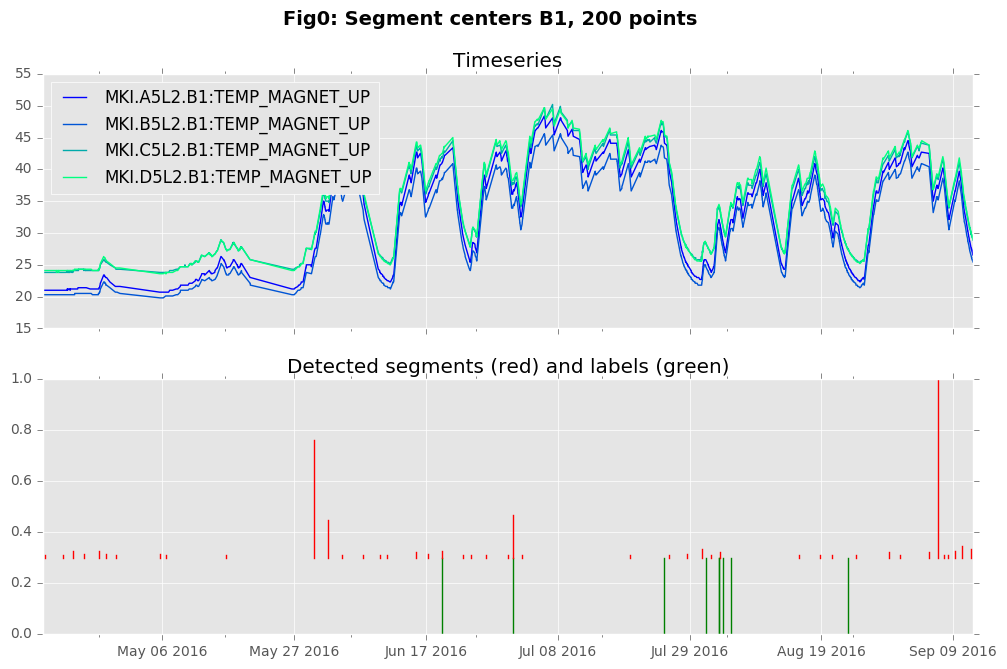

In [9]:
evaluation.plot_segments_series(B1_30, "TEMP_MAGNET_UP", evolution_segments_B1[0], labels_B1, 'Fig0: Segment centers B1, 200 points ')

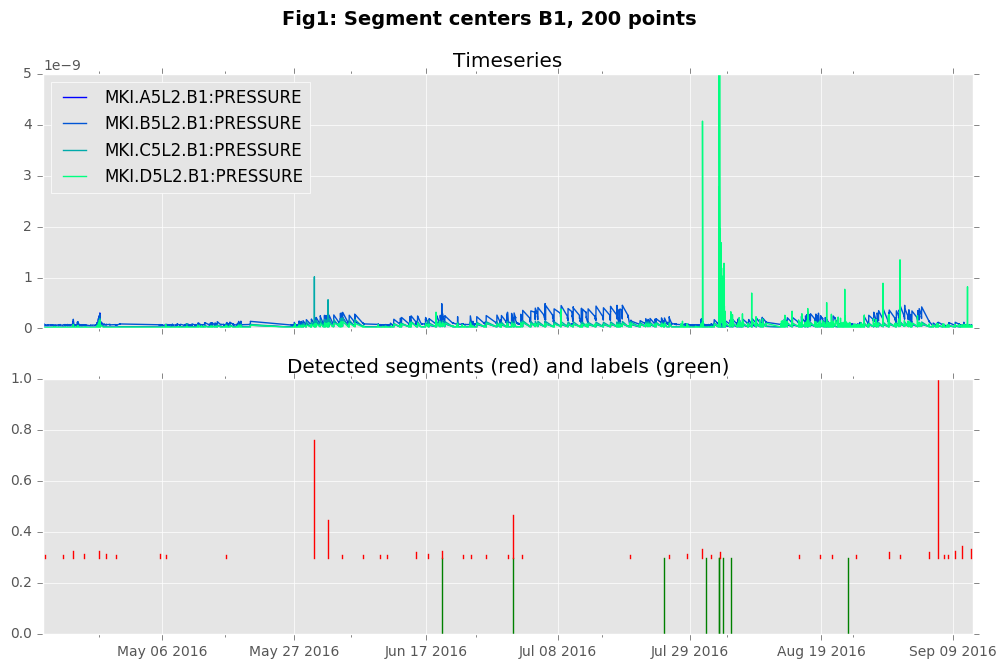

In [10]:
evaluation.plot_segments_series(B1_30, "PRESSURE", evolution_segments_B1[0], labels_B1, 'Fig1: Segment centers B1, 200 points ')

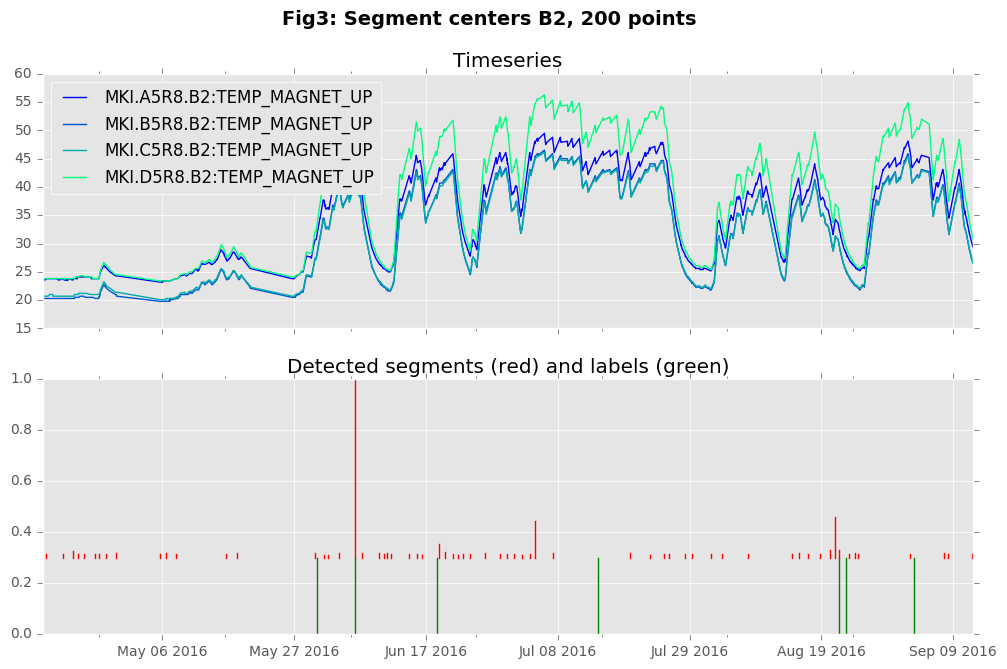

In [11]:
evaluation.plot_segments_series(B2_30, "TEMP_MAGNET_UP", evolution_segments_B2[0], labels_B2, 'Fig3: Segment centers B2, 200 points ')

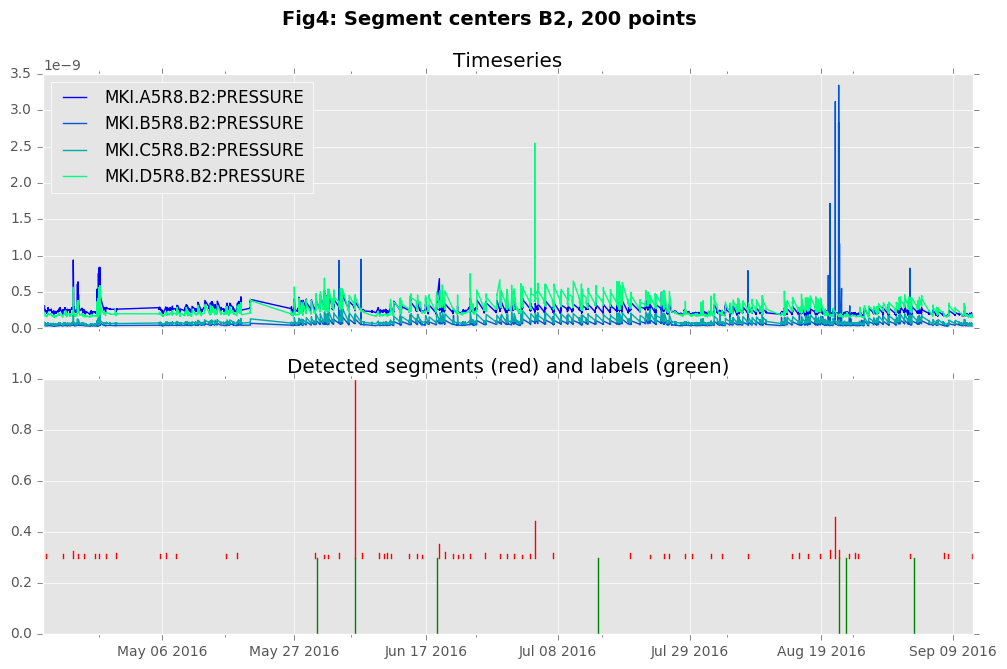

In [12]:
evaluation.plot_segments_series(B2_30, "PRESSURE", evolution_segments_B2[0], labels_B2, 'Fig4: Segment centers B2, 200 points ')

## Supervised Learning

In [13]:
# label the data
B1_30_s_supervised = B1_30_s.copy()
B1_30_s_supervised['anomaly'] = 0
for anom_ts in labels_B1.index:
    start = anom_ts - pd.Timedelta(12, unit='h')
    B1_30_s_supervised.loc[start:anom_ts, 'anomaly'] = 1

In [14]:
from sklearn.ensemble import RandomForestClassifier
training = B1_30_s_supervised.loc[:'2016-08-03 18:00:00']
test = B1_30_s_supervised.loc['2016-08-03 18:00:00': ]
display('Training set size: {}'.format(training.shape[0])) 
display('Test set size: {}'.format(test.shape[0]))
display('Labels in training: {}'.format(labels_B1.loc[:'2016-08-03 18:00:00'].shape[0]))
display('Labels in test: {}'.format(labels_B1.loc['2016-08-03 18:00:00':].shape[0]))

train_features = training.ix[:, ~B1_30_s_supervised.columns.isin(['log_prob', 'anomaly'])]
train_labels = training['anomaly']
test_features = test.ix[:, ~B1_30_s_supervised.columns.isin(['log_prob', 'anomaly'])]
test_labels = test['anomaly']


'Training set size: 31954'

'Test set size: 13768'

'Labels in training: 7'

'Labels in test: 2'

In [15]:
clf = RandomForestClassifier(class_weight='balanced').fit(train_features, train_labels)
predictions = clf.predict(test_features)

In [16]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
display(precision_recall_fscore_support(test_labels, predictions))
display(confusion_matrix(test_labels, predictions, labels=[1, 0]))

(array([ 0.95775471,  0.95348837]),
 array([ 0.99969484,  0.12424242]),
 array([ 0.97827548,  0.21983914]),
 array([13108,   660]))

array([[   82,   578],
       [    4, 13104]])

In [29]:
test_features = test_features.copy()
test_features['prediction'] = predictions
# for segmentation later
test_features['log_prob'] = 0
detected = test_features[test_features['prediction'] == 1]
detected_w_label, labeled_w_detected = evaluation.compare_detected_w_labeled(detected, labels_B1)
display(labeled_w_detected)

nb_detected
timestamps                      
2016-06-19 13:14:00            0
2016-06-30 21:23:00            0
2016-07-24 22:19:48            0
2016-07-31 16:00:00            0
2016-08-02 17:28:00            0
2016-08-02 17:50:00            0
2016-08-03 08:05:00            0
2016-08-04 14:03:41           82
2016-08-23 06:53:47            0

Quick test with RandomForestClassifier detects 1 labeled anomaly

In [30]:
supervised_segmenter = evaluation.AnomalySegmenter()
segments = supervised_segmenter.create_segments(detected)

In [33]:
def plot_segments_series(data, series_name, segments, labels=None, title='Segment centers plotted on timeseries'):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
    regex = '^MKI.*:%s$' % series_name
    timeseries = data.filter(regex=regex)
    timeseries.plot(ax=ax1, colormap='winter', kind='line', linestyle='solid')

    ax2_title = "Detected segments"
    if labels is not None:
        for label in labels.index:
            ax2.axvline(label, ymin=0, ymax=0.3, color='green')
        ax2_title = "Detected segments (red) and labels (green)"

    segment_centers = [segment.get_mean_ts() for segment in segments]
    segment_scores = np.array([segment.get_score() for segment in segments])
    for center, score in zip(segment_centers, segment_scores):
        plt.axvline(center, ymin=0.3, ymax=1, color='red')
        # plt.text(center, 1, score, rotation='vertical')
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax1.set_title("Timeseries")
    ax2.set_title(ax2_title)

In [35]:
plot_segments_series(B1_30, "TEMP_MAGNET_UP", segments, labels_B1, 'Fig5: Segment centers B1, supervised')